# Neural Ordinary Differential Equations

Prerequisites:
- Differential Equations basics
- Python and PyTorch basics

## Revision of differential equations

Implicit form of ordinary differential equation is:

<center>$
\begin{align}
F(\frac{dz}{dt}, z(t), t) = 0 \tag{1}
\end{align}
$

Implicit form is more general than explicit one (every implicit equation can be transformed to explicit but not vice versa). For simplicity only about the explicit form will be used.

---

Explicit form of ordinary differential equation is:

<center>$
\begin{align}
\frac{dz}{dt} = f(z(t), t) \tag{2}
\end{align}
$

From the view of dynamical systems, $z(t)$ is state at time t and function $f$ defines change of state (slope). Solving this equation results a family of curves or a single curve if initial state $z_0 = z(t_0)$ is given (each curve in family has its initial state). Let $t_0$ be start time and $t_1$ be end time ($z(t_1)$ is last state). 

How to solve this equation? Assumption is that start time, state at that start time and function of change is defined then equation might be solver analytically:

<center>$
\begin{align}
z(t_1) = z(t_0) + \int_{t_0}^{t_1}{f(z(t), t)dt} \tag{3}
\end{align}
$

Problem is that it might be very hard or event impossible to calculate integral value. Instead it is possible to use numerical method which can approximate the value of $z(t_1)$ (or whole curve sequence) by taking small steps and following slope ($\frac{dz}{dt}$) defined by function $f$. One of simplest numerical methods is [Euler Method](https://en.wikipedia.org/wiki/Euler_method):

<center>$
\begin{align}
z_{i+1} = z_{i} + h \cdot f(z_{i}, t_{i}) \tag{4}
\end{align}
$
where $z_0 = z(t_0)$ and $z_N = z(t_{last})$

![](images/euler_method.jpeg)

Detailed explanation of Euler method can be found [here](https://x-engineer.org/euler-integration/).

---

Example is given for better understanding of Euler method:

<center>$
\begin{align}
z(t) := sin(t) \Rightarrow \frac{dz}{dt} = cos(t)
\end{align}
$ 

In this case $sin(t)$ is solution to differential equation $\frac{dz}{dt} = cos(t)$. If $\frac{dz}{dt} = f(z(t), t) = cos(t)$ is solved analytically then it is expected to get approximation of the $sin(t)$ function.

In [1]:
# All imports (for full notebook)
from abc import ABC, abstractmethod
from typing import Callable, Union, Tuple, Any, Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd


torch.manual_seed(0)
np.random.seed(42)
torch.set_printoptions(precision=2, sci_mode=False)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-io_wxr4q because the default path (/home/madzemovic/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Definition of abstract ODESolver which defines solver interface
class ODESolver(ABC):
    @abstractmethod
    def solve(
        self, 
        z0: torch.Tensor, 
        t0: torch.Tensor, 
        t1: torch.Tensor, 
        f: Union[nn.Module, Callable], 
        return_all_states: bool = False
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Solves ODE

        Args:
            z0: Start state ~ z(t0)
            t0: Start time
            t1: End time
            f: State change function (slope)
            return_all_states: Return all intermediate states

        Returns:
            End state ~ z(t1) and end time point ~ t1 if return_all_states == False
            else return all states and time points
        """
        pass
    
    def __call__(
        self, 
        z0: torch.Tensor, 
        t0: torch.Tensor, 
        t1: torch.Tensor, 
        f: Union[nn.Module, Callable], 
        return_all_states: bool = False
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        solve() method wrapper
        """
        return self.solve(z0, t0, t1, f, return_all_states=return_all_states)
    

class EulerMethod(ODESolver):
    def __init__(self, max_step_size: float):
        """
        Simplest ODESolver

        Args:
            max_step_size: Max step size (higher step size ~ lower precision)
        """
        super().__init__()

        self._max_step_size = max_step_size

    def solve(
        self, 
        z0: torch.Tensor, 
        t0: torch.Tensor, 
        t1: torch.Tensor, 
        f: Union[nn.Module, Callable],
        return_all_states: bool = False
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # noinspection PyTypeChecker
        n_steps = int(torch.ceil(torch.abs(t1 - t0) / self._max_step_size).max().item())
        h = (t1 - t0) / n_steps  # step size
        

        # Initial state
        t = t0
        z = z0

        zs = [z0]
        ts = [t0]
        for _ in range(n_steps):
            z = z + f(z, t) * h
            t = t + h
            
            if return_all_states:
                zs.append(z)
                ts.append(t)
                
        if return_all_states:
            zs, ts = torch.stack(zs), torch.stack(ts)
            return zs, ts

        return z, t  # only last state

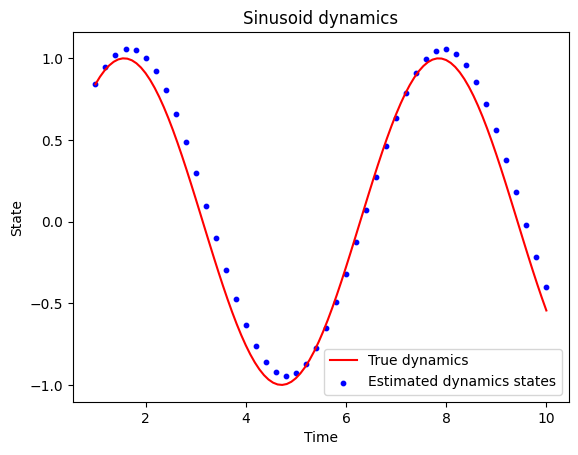

In [3]:
def cosine_dynamics(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Cosine function
    
    Args:
        x: Previous state (not relevant but still keeping it as argument for consistency)
        t: Time
        
    Returns:
        Cosine value of t
    """
    return torch.cos(t)

ts = torch.linspace(1, 10, 100)
t0, t1 = torch.tensor(1.0), torch.tensor(10.0)
z0 = torch.sin(t0)
ode_true = torch.sin(ts)

ode_solver = EulerMethod(0.2)
zs_hat, ts_hat = ode_solver(z0, t0, t1, cosine_dynamics, return_all_states=True)

plt.plot(ts, ode_true, color='red', label='True dynamics')
plt.scatter(ts_hat, zs_hat, color='blue', s=10, label='Estimated dynamics states')
plt.title('Sinusoid dynamics')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

It can be seen that the solver approximates sinusoid function given the change of state at each time point. In this example Euler method uses step `0.2` which is very high. If lower step is used like `0.01` then the method is more accurate and the estimation can visually perfectly match.

The question is: Is it possible to learn state change function f? The answer comes with a method (paper) - **Neural Ordinary Differential Equations**

## Combining differential equations with neural networks

If function $f$ is learnable function (like a neural network) then dynamics for observed system coult be learnt. In that case there are learnable parameters $\theta$ as an input to (or as a part of) function f:

<center>$
\begin{align}
\frac{dz}{dt} = f(z(t), t, \theta)
\end{align}
$

During inference time this is not that much different than classical ordinary differential equation. Euler method (or some more efficient method) can be used to numerically solve $z(t)$. Abstract ODE solver is defined as: $ODESolve(z_0, f, t_0, t_1, \theta)$

![](images/node-basics.drawio.png)

Given the input state value $z(t_0)$ solver (with parameters $\theta$) can be used to get estimated value $\hat{z}(t_1)$. Goal is to minimize the loss function $L = L(z, \hat{z})$

![](images/node-forward-pass.png)

Problem: It might be hard and inefficient to backpropagate through the ODESolver algorithm. Alternative is to use ODESolver as a blackbox but we still need a way to backpropagate throught that blackbox. In next section it will be seen how backpropagation can be performed.

### Pontryagin Adjoint Method

Gradients can be computed using Pontryagin adjoint method. Formal proof of this method can be found in [Appendix B.1 of the paper](https://arxiv.org/pdf/1806.07366.pdf). Proof is easy to follow but is excluded from here since it would take a lot of space. With this method it is possible to determine gradient $a(t) = \frac{dL}{dz(t)}$ of the loss on the hidden state $z(t)$ at each time point. Gradients are calculated backward in time: 

<center>$
\begin{align}
\frac{a(t)}{dt} = -a(t) \cdot \frac{df(z(t), t, \theta)}{dz(t)} \tag{5}
\end{align}
$

ODESolver can be used to calculate $a(t)$ in for all time points $[t_N, t_{N-1}, ..., t_1, t_0]$ backward in time:

<center>$
\begin{align}
a(t_0) = a(t_N) + \int_{t_N}^{t_0} \frac{da(t)}{dt}dt = a(t_N) - \int_{t_N}^{t_0} a(t) \cdot \frac{df(z(t), t, \theta)}{dz(t)}dt \approx ODESolve(a(t_N), t_N, t_0, \frac{df(z(t), t, \theta)}{dz(t)}) \tag{6}
\end{align}
$

Arguments for ODESolve are $a(t_N)$, $t_N$, $t_0$ and $\frac{df(z(t), t, \theta)}{dz(t)}$:
- <left> $a(t_N)$ is initial state equal to $\frac{dL}{dz(t_N)}$ and this gradient can be calculated directly from loss function.
- $t_N$, $t_0$ are known time points that correspond to the forward pass time points.
- $\frac{df(z(t), t, \theta)}{dz(t)}$ is calculated using automatic differentiation library (pytorch autograd). Note: It is also required to calculate $z(t)$ at each step (ODESolve backward in time).

![](images/node-adjoint-method.png)

In previous case it is assumed that loss only depends on last time point $t_N$. If function L depends also on intermediate time points $t_1$, $t_2$, ..., $t_{N-1}$, etc., then adjoint method can be repeated for each of intervals $[t_{N-1}, t_{N-2}]$, $[t_{N-2}, t_{N_3}]$ in backward order and sum up the obtained gradients. That is why there are "those jumps" for adjoint curve at each time point (look at the image). At point $t_N$ only $\frac{dL}{dz(t_N)}$ is considered but at $t_{N-1}$ it is also required add $\frac{dL}{dz(t_{N-1})}$ (like on the image).

### Augmented Adjoint Method

Next goal is to generalize adjoint method to also gather gradients with respect to time $t$ and constant (they do not depent on time) model parameters $\theta$. Their differential equations (which defines their function of state change) can be written as:

<center>$
\begin{align}
\frac{dt(t)}{dt} = 1, \frac{d\theta(t)}{dt} = 0 \tag{7}
\end{align}
$

Elements $z$ state, $\theta$ parameters and $t$ time can be combined into a single augmented state $z_{aug}$:

<center>$
\begin{align}
\frac{d}{dt}
\begin{bmatrix}
    z \\
    \theta \\
    t
\end{bmatrix}
(t) = f_{aug}([z, \theta, t]) :=
\begin{bmatrix}
    \frac{dz(t)}{dt} \\
    \frac{d\theta(t)}{dt} \\
    \frac{dt(t)}{dt}
\end{bmatrix}
= 
\begin{bmatrix}
    f(z(t), t, \theta) \\
    0 \\
    1
\end{bmatrix} \tag{8}
\end{align} 
$

Then corresponding $a_{aug}$ is:

<center>$
\begin{align}
a_{aug}(t) := 
\begin{bmatrix}
    a \\
    a_{\theta} \\
    a_t
\end{bmatrix}
(t)
= 
\begin{bmatrix}
    \frac{dL}{dz(t)} \\
    \frac{dL}{d\theta(t)} \\
    \frac{dL}{dt(t)}
\end{bmatrix} \tag{9}
\end{align}
$

Based on adjoint method formula we have:

<center>$
\begin{align}
\frac{da_{aug}(t)}{dt} = -a_{aug}(t) \cdot \frac{df_{aug}(z_{aug}(t), t, \theta)}{dz_{aug}} \tag{10}
\end{align}
$
    
Element $\frac{df_{aug}(z_{aug}(t), t, \theta)}{dz_{aug}}$ is equal to Jacobian of $f$ which has form:
   
<center>$
\begin{align}
\begin{bmatrix}
    \frac{df}{dz} & \frac{df}{d\theta} & \frac{df}{dt} \\
    0 & 0 & 0 \\
    0 & 0 & 0
\end{bmatrix} \tag{11}
\end{align}
$
    
Element $a_{aug}(t)$ is equal to $[a(t), a_{\theta}(t), a_t(t)]$ and by multiplying it with previous element (matrix multiplication: 1x3 times 3x3 gives 1x3) we get: 
    
<center>$
\begin{align}
\frac{da_{aug}(t)}{dt} = -[a \cdot \frac{df}{dz}, a \cdot \frac{df}{d\theta}, a \cdot \frac{df}{dt}] \tag{12}
\end{align}
$
    
Last missing element for augmented state method is to calculate initial states $a_t(t_{N})$ and $a_{\theta}(t_N)$ (we know $a(t_{N})$ from original adjoint method). Let $a_{\theta}(t_N) = 0$:
    
<center>$
\begin{align}
a_{\theta}(t_0) = a_{\theta}(t_N) - \int_{t_N}^{t_0}{a(t) \cdot \frac{df(z(t), t)dt}{d\theta}}
= - \int_{t_N}^{t_0}{a(t) \cdot \frac{df(z(t), t)dt}{d\theta}} \tag{13}
\end{align}
$
    
Similar with time parameter: 

<center>$
\begin{align}
a_t(t_0) = a_t(t_N) - \int_{t_N}^{t_0}{a(t) \cdot \frac{df(z(t), t)dt}{dt}} \tag{14}
\end{align}
$
    
For initial (starting) state it is required to have $a_t(t_N)$:
    
<center>$
\begin{align}
a_t(t_N) = \frac{dL}{dt(t_N)} = \frac{dL}{dz(t_N)}^T \cdot \frac{dz(t_N)}{dt(t_N)} 
= a(t_N)^T \cdot f(z(t_N), t_N, \theta) \tag{15}
\end{align}
$

### Full Algorithm

**References:**
- $t_1$ - initial state time point
- $t_0$ - end state time point (adjoin method goes backward in time)
- $\theta$ - model parameters
- $z(t_1)$ - initial state
- $\frac{dL}{dz(t_1)}$ - loss gradient (implementation: calculated using pytorch autograd - automatic differentiation module)

![](images/node-algorithm.png)

**Implementation notes:**
- step 1: $\frac{dL}{dt(t_1)}$ - This gradient can be calcualted directly from (15) (implementation: simple matrix multiplication)
- step 2: $s_0$ - Initial augmented state (implementation: simple vector or tensor concatenation)
- step 3: aug_dynamics - Augmented adjoint method (implementation: based on ODEF module - use PyTorch automatic differentiation module to calculate Jacobian-vector product)
- step 4: Apply ODESolve and unpack vector (or tensor)

## Benefits of NODE (Neural Ordinary Differential Equations) models

This sections contains set of explained NODE benefits.

### Memory efficiency

If ODESolver are used as a blackbox and direct backpropagation through them (algorithm) is avoided then there is no need to store intermediate quantities of the forward pass and models can be trained with cost as a function of depth (one of the main drawbacks of deep neural networks)

### Adaptive computation

If step size is decreased for Euler method (or any other solver) then the method is more accurate but requires more computational power. When step size is increased for Euler method (or any other solver) then the method is less accurate but requires less computation power. It is possible to use change and adapt accuracy and computation power requirements. Example: Use lower step size during training but higher step size during inference in order for the model to work in real time.

![](images/node-nfe.png)

In this case `NFE` stands for `Number of function evaluations` (solver function calls). Looking at above image from NODE paper there are following conclusions:
- (a): When more evaluations are used during inference (forward pass) then numerical error is lower. This is computational cost and accuracy tradeoff.
- (b): Total time spent in inference is strongly correlated with the number of function evaluations.
- (c): Number of calls for function evaluation in backward propagation (adjoint ODE) is roughly half of the forward pass (interesting results).
- (d): There are more function evaluations in later stages (this is not the case for Euler method).


This can be one of the use cases for NODE models.

Further reading: 
- [Vid-ODE: Continuous-Time Video Generation with Neural Ordinary Differential Equation](https://arxiv.org/pdf/2010.08188.pdf)

### Scalable and invertible normalizing flows

Work in progress...

### Continuous time-series models

One of the main assumptions of time series models like RNN (LSTM, GRU) is that data steam comes with constant period between two time points (distance between two time points is constant in case of no missing data). NODE model can naturally work with data stream with non constant period between two time points.

This would be one of the main usecases for NODE models: 
- Incorporating data which arrives at arbitrary times.
- Working with time series data which has many (consecutive) missing values.
- Otherwise (in case of regularly sampled time series) it might be better to use standard RNN models.

Further reading: 
- [Latent ODEs for Irregularly-Sampled Time Series](https://proceedings.neurips.cc/paper/2019/file/42a6845a557bef704ad8ac9cb4461d43-Paper.pdf)
- [Neural Controlled Differential Equations for Irregular Time Series](https://proceedings.neurips.cc/paper/2020/file/4a5876b450b45371f6cfe5047ac8cd45-Paper.pdf)

## Implementing NODE from scratch

It is advised to read [A Gentle Introduction to PyTorch autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) before going through implementation. Based on **Full algorithm section** (recheck implementation notes and algorithm pseudocode).

Reminder:
<center>$
\begin{align}
\frac{a(t)}{dt} = -a(t) \cdot \frac{df(z(t), t, \theta)}{dz(t)}
\end{align}
$
    
In case $a(t)$ is a vector then it is more accurate to write:
    
<center>$
\begin{align}
\frac{a(t)}{dt} = -a(t)^T \cdot \frac{df(z(t), t, \theta)}{dz(t)}
\end{align}
$
   
Pytorch autograd function [torchgrad.autograd.grad](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html#torch.autograd.grad) is used to calculate vector-Jacobian product where "vector" is equal to $a$.

In [4]:
DefaultODESolver = EulerMethod(0.05)  # Default ODESolver

In [5]:
# This module represents state change function in ODE
class ODEF(nn.Module):
    """
    Parametrized dynamics function (dz/dt) superclass
    (does not have forward pass defined)
    """
    # noinspection PyMethodMayBeStatic
    def forward_with_grad(self, z: torch.Tensor, t: torch.Tensor, grad_outputs: torch.Tensor) \
            -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Performs forward pass and calculates:
            - da/dt = df/dz * a
            - da_t/dt = df/dt * a
            - a_theta/dt = df/dtheta * a

        Args:
            z: State
            t: Time
            grad_outputs: Grad outputs (a)

        Returns:
            z, a_dfdz, a_dfdt, a_dfdtheta
        """
        batch_size = z.shape[0]  # required for postprocessing

        z_end = self.forward(z, t)
        a = grad_outputs  # dL/dz(t)

        # Reference: `https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html`
        # - Autograd performs operation J.T @ v (numpy notation)
        #   where J is Jacobian and v is output gradient (example: loss)
        # - In this case: v == a, and J.T == df/dp where p is parameter (z, t or theta)
        #   so we get df/dz * a, df/dt * a and df/dtheta * a
        #   which is exactly what we need for a, a_t and a_theta
        parameters = tuple(self.parameters())
        a_dfdz, a_dfdt, *a_dfdtheta = torch.autograd.grad(
            outputs=(z_end,), # forward pass outputs
            inputs=(z, t) + parameters,  # z, t and theta
            grad_outputs=(a,),  # gradient vector of the loss
            allow_unused=True,
            retain_graph=True
        )

        # grad function automatically sums gradients -> expanding them
        # autograd returns None if variables are not used in forward pass
        # -> replacing None values with zero gradients
        if a_dfdz is None:
            a_dfdz = torch.zeros_like(z).to(z)

        if a_dfdtheta is not None:
            a_dfdtheta = torch.cat([p_grad.flatten() for p_grad in a_dfdtheta]).unsqueeze(0)
            a_dfdtheta = a_dfdtheta.expand(batch_size, -1) / batch_size
        else:
            a_dfdtheta = torch.zeros(batch_size, len(parameters)).to(z)

        if a_dfdt is not None:
            a_dfdt = a_dfdt.expand(batch_size, 1) / batch_size
        else:
            a_dfdt = torch.zeros(batch_size, 1).to(z)

        return z_end, a_dfdz, a_dfdt, a_dfdtheta

    @property
    def flat_parameters(self):
        """
        Returns: Returns flat parameters tensor
        """
        return torch.cat([p.flatten() for p in self.parameters()])

### Minibatches in NODE

It is possible to apply ODESolver in parallel for multiple states $z_{i}(t)$ if they share same intermediate time points in solver (this can be forced). In that case all states in single time point can be stacked and processed as a single "batch". Minibatch format: (time_length, batch_size, state_tensor_shape).

In [6]:
# Implementation of Adjoint method
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def create_aug_dynamics(batch_size, shape, func) -> Callable:
        """
        Creates augmented dynamics function

        Args:
            batch_size: Batch size
            shape: Shape of z tensor
            func: State change function

        Returns:
            augmented dynamics functions
        """
        n_dim = round(np.prod(shape))

        def aug_dynamics(aug_z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
            """
            Augmented state change function

            Args:
                aug_z: flat tensor (z, a, a_t, a_theta) with shape (batch_size, n_dim+ndim+1+n_params)
                    where n_dim is z flat tensor dimension and n_params is theta (params) flat tensor dimensions
                t: Time

            Returns:
                Augmented (z_end, -a_dfdz, -a_dfdt, -a_dfdtheta) as flat tensor
            """
            # Input is flat (z, a, a_t, a_theta) - ignore a_t and a_theta
            z, a = aug_z[:, :n_dim], aug_z[:, n_dim:2*n_dim]

            z = z.view(batch_size, *shape)
            a = a.view(batch_size, *shape)
            with torch.set_grad_enabled(True):
                z = z.requires_grad_()
                t = t.requires_grad_()
                z_end, a_dfdz, a_dfdt, a_dfdtheta = func.forward_with_grad(z, t, grad_outputs=a)

            # Output has to be single tensor
            # In adjoint a(t) formula we use negative value of integral
            z_end = z_end.view(batch_size, n_dim) # flatten for concat
            a_dfdz = a_dfdz.view(batch_size, n_dim)  # flatten for concat
            return torch.cat([z_end, -a_dfdz, -a_dfdtheta, -a_dfdt], dim=-1)  # TODO: Reorder dfdt and dfdtheta

        return aug_dynamics

    @staticmethod
    def forward(ctx: Any, z0: torch.Tensor, t: torch.Tensor, flat_theta: torch.Tensor, func: ODEF) -> torch.Tensor:
        # z.shape == (time_len, batch_size, *vector_shape)
        # z0.shape == (batch_size, *vector_shape)
        # t.shape == (time_len, 1, 1)
        assert len(t.shape) == 3, f'Expected shape is (time_len, 1, 1) but found {t.shape}'
        n_steps = t.shape[0]

        zs = [z0]
        with torch.no_grad():
            # ODESolver is used a blackbox (disable autograd)
            for i in range(n_steps - 1):
                z0, _ = DefaultODESolver.solve(z0, t[i], t[i+1], func)
                zs.append(z0)

        zs = torch.stack(zs)  # Stack all states into a single vector
        ctx.func = func
        ctx.save_for_backward(zs, t, flat_theta)
        return zs

    @staticmethod
    def jvp(ctx: Any, dLdz: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, None]:
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        z, t, flat_parameters = ctx.saved_tensors
        time_len, batch_size, *z_shape = z.size()
        n_dim = round(np.prod(z_shape))
        n_params = flat_parameters.shape[0]

        augmented_dynamics = ODEAdjoint.create_aug_dynamics(batch_size, z_shape, func)

        dLdz = dLdz.view(time_len, batch_size, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            # Variables to store adjoint states
            a = torch.zeros(batch_size, n_dim).to(dLdz)
            a_theta = torch.zeros(batch_size, n_params).to(dLdz)
            a_t = torch.zeros(time_len, batch_size, 1).to(dLdz)  # adjoint t needs to be stored for all timestamps

            for i_t in range(time_len-1, 0, -1):
                # Iteration steps:
                # 1. Form augmented state
                # 2. Use ODESolve with augmented dynamics
                # Calculate z backward in time (required for a(t) evaluation and augmented state)
                z_i = z[i_t]
                t_i = t[i_t]
                dzdt_i = func(z_i, t_i).view(batch_size, n_dim)

                # Math details: For augmented state we need (z, a, a_t, a_theta)
                # a_t = dL/dt
                # dL/dt = dL/dz(t) @ dz(t)/dt
                #       = a(t) * func(z, i, theta)
                # Note: we don't need theta in implementation since it is part of func (Module object)
                # Implementation details: L is scalar, t is scalar, z is vector of dimension n
                # hence dLdz shape is (1, n) and dzdt shape is (1, n) and dLdt shape is (1, 1) - vector scalar product
                dLdz_i = dLdz[i_t]
                # bmm is batch matrix multiplication (in parallel)
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), dzdt_i.unsqueeze(-1))[:, 0]

                # Form augmented state z0_aug = (z, a, a_t, a_theta) = (z, dL/dz, dL/dt, dL/dtheta)
                # We need to sum up gradients of loss function for all timestamps backward in time
                # a_theta is set to 0
                a = a + dLdz_i
                a_t[i_t] = a_t[i_t] - dLdt_i
                a_theta_i = torch.zeros(batch_size, n_params).to(z_i)  # We defined dL/dtheta as 0
                z_i = z_i.view(batch_size, n_dim) # flatten for concat
                z0_aug = torch.cat([z_i, a, a_t[i_t], a_theta_i], dim=-1)

                # Solve augmented system backwards
                dzdt_aug, _ = DefaultODESolver.solve(z0_aug, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                a[:] = dzdt_aug[:, n_dim:2*n_dim]
                a_theta[:] += dzdt_aug[:, 2*n_dim:2*n_dim + n_params]
                a_t[i_t-1] = dzdt_aug[:, 2*n_dim + n_params:]

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients
            dzdt_0 = func(z[0], t[0])
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), dzdt_0.view(batch_size, -1).unsqueeze(-1))[:, 0]

            # Adjust adjoint states
            a += dLdz_0
            a_t[0] = a_t[0] - dLdt_0
        return a.view(batch_size, *z_shape), a_t, a_theta, None

    @staticmethod
    def backward(ctx: Any, dLdz: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, None]:
        # Alias for jvp
        return ODEAdjoint.jvp(ctx, dLdz)

In [7]:
class NeuralODE(nn.Module):
    """
    Wrapper for ADJoint function
    """
    def __init__(self, func: ODEF):
        super(NeuralODE, self).__init__()
        self.func = func

    def forward(self, z0: torch.Tensor, t: torch.Tensor, full_sequence: bool = False) -> torch.Tensor:
        z = ODEAdjoint.apply(z0, t, self.func.flat_parameters, self.func)

        if full_sequence:
            return z
        return z[-1]

## Example: Spiral Dynamics

Process for training NODE does not differ from training normal neural networks.

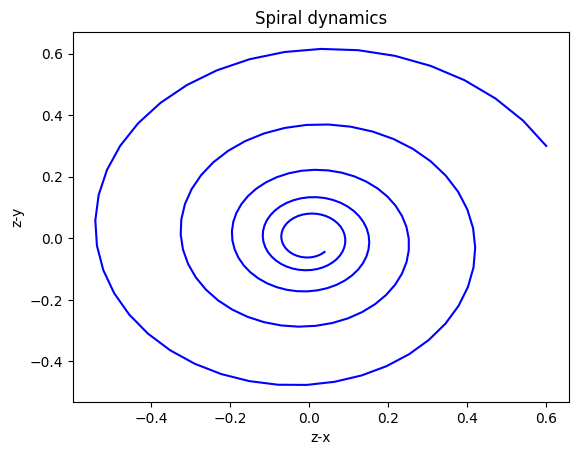

In [8]:
# Testing NODE with "pretrained" (predefined weights) model
class Linear2dTimeInvariantODEF(ODEF):
    def __init__(self, W: Optional[torch.Tensor] = None):
        """
        Special case of 2d ODEF
        
        Linear - applies linear transformation
        TimeInvariant - does not use `t` input value
        
        Args: 
            W: 2d matrix (parameters)
        """
        super(Linear2dTimeInvariantODEF, self).__init__()
        assert W is None or W.shape == (2, 2), f'Wrong shape for weights! Got {W.shape} but expected (2, 2)!'
        
        self._linear = nn.Linear(2, 2, bias=False)
        if W is not None:
            self._linear.weight.data = W
        
    def forward(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self._linear(z)

    
def plot_2d_state_sequence(zs: np.ndarray, color: str = 'blue', title: str = 'Dynamics', label: str = '') -> None:
    """
    Plot 2d sequence
    
    Args:
        zs: State sequence
        color: Sequence color
        title: Plot title
        label: Sequence label
    """
    assert len(zs.shape) >= 3 and zs.shape[1] == 1
    plt.plot(zs[:, 0, 0], zs[:, 0, 1], color=color, label=label)
    plt.xlabel('z-x')
    plt.ylabel('z-y')
    plt.title(title)
    
    

# Spiral dynamics example
spiral_dynamics = Linear2dTimeInvariantODEF(torch.tensor([[-0.1, -1.0], [1.0, -0.1]]))  # dynamics definition
node_spiral_dynamics = NeuralODE(spiral_dynamics)  # node wrapper
ts = torch.linspace(0, 30, 200).view(-1, 1, 1)  # time points
z0 = torch.tensor([[0.6, 0.3]])  # initial state

zs = node_spiral_dynamics(z0, ts, full_sequence=True)
zs = zs.detach().cpu().numpy()
    
plot_2d_state_sequence(zs, title='Spiral dynamics')
plt.show()

### Training 

Goal is to initialize random weights and train model to learn spiral dynamics.

In [9]:
def train(
    model: NeuralODE, 
    zs_true: torch.Tensor, 
    ts: torch.Tensor,
    n_steps: int = 1000
) -> None:
    """
    Train Spiral Dynamics model
    
    Args:
        model: Model to train
        zs_true: True state sequence values
        ts: Time points
        n_steps: Number of training steps
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_func = nn.MSELoss()
    n_time_points = zs.shape[0]
    
    history = []
    loss_ema = 0.0
    
    with tqdm(range(1, n_steps+1)) as pbar:
        for step_index in pbar:
            # Sample batch
            start_time_point_index = np.random.randint(0, n_time_points-2)
            delta = np.random.randint(2, 32)
            end_time_point_index = np.random.randint(start_time_point_index+1, 
                min(start_time_point_index + delta, n_time_points-1))

            zs_true_sample = zs_true[start_time_point_index:end_time_point_index]
            ts_sample = ts[start_time_point_index:end_time_point_index]
            z0 = zs_true_sample[0]

            # forward
            zs_hat = model(z0, ts_sample, full_sequence=True)

            # loss
            loss = loss_func(zs_hat, zs_true_sample)
            loss_scalar = loss.detach().cpu().item()
            history.append(loss_scalar)
            loss_ema = loss_ema * 0.9 + loss * 0.1

            # backward
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            
            pbar.set_description(f'Mean Squared Error Loss: {loss_ema.detach().cpu().item():.4f}')
        
    return history

  0%|          | 0/2500 [00:00<?, ?it/s]

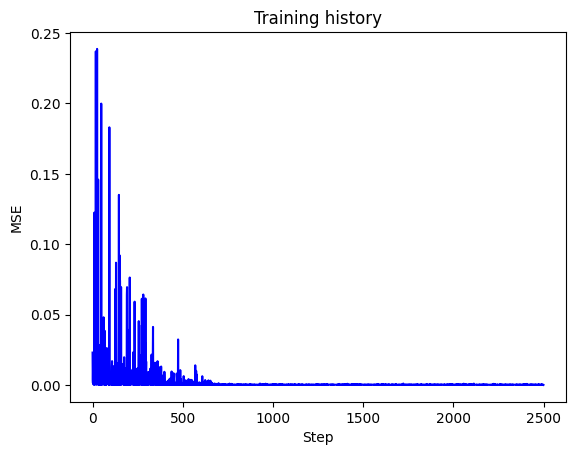

In [10]:
# Real dynamics (ground truth)
spiral_dynamics = Linear2dTimeInvariantODEF(torch.tensor([[-0.1, -1.0], [1.0, -0.1]]))  # dynamics definition
node_spiral_dynamics = NeuralODE(spiral_dynamics)  # node wrapper

# Model with random weights to learn the dynamics
node_model = NeuralODE(Linear2dTimeInvariantODEF())

# Create dataset - train
ts_train = torch.linspace(0, 30, 200).view(-1, 1, 1)  # time points
z0_train = torch.tensor([[0.6, 0.3]])  # initial state
zs_train = node_spiral_dynamics(z0_train, ts_train, full_sequence=True)
zs_train = zs_train + torch.randn_like(zs_train) * 0.01  # add noise

# Create dataset - val
ts_val = torch.linspace(30, 35, 33).view(-1, 1, 1)  # time points
z0_val = zs_train[-1]
zs_val = node_spiral_dynamics(z0_val, ts_val, full_sequence=True) # no noise

# Train model
history = train(node_model, zs_train, ts_train, n_steps=2500)

# Plot training history
plt.plot(history, color='blue')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.title('Training history')
plt.show()

In [11]:
# Weights should be close to real dynamics
node_model.func._linear.weight

Parameter containing:
tensor([[-0.08, -1.01],
        [ 0.98, -0.10]], requires_grad=True)

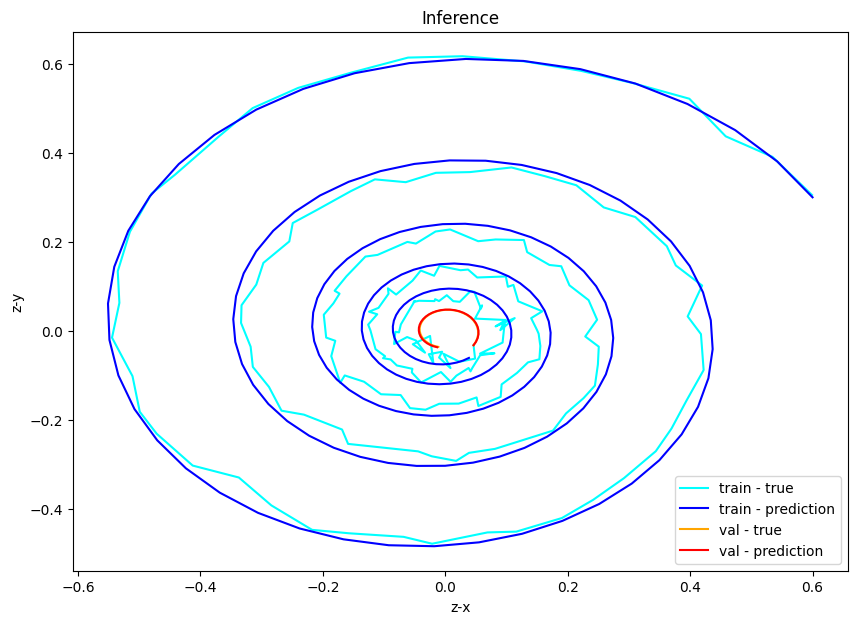

In [12]:
# Visualize model results (on training and validation datasets)
zs_train_hat = node_model(z0_train, ts_train, full_sequence=True)
zs_train_hat = zs_train_hat.detach().cpu().numpy()

zs_val_hat = node_model(z0_val, ts_val, full_sequence=True)
zs_val_hat = zs_val_hat.detach().cpu().numpy()

zs_train = zs_train.detach().cpu().numpy()
zs_val = zs_val.detach().cpu().numpy()

plt.figure(figsize=(10, 7))
plot_2d_state_sequence(zs_train, color='cyan', label='train - true')
plot_2d_state_sequence(zs_train_hat, color='blue', label='train - prediction')
plot_2d_state_sequence(zs_val, color='orange', label='val - true')
plot_2d_state_sequence(zs_val_hat, title='Inference', color='red', label='val - prediction')
plt.legend()
plt.show()

Even with signifficant noise in the training dataset the Neural NODE model managed to learn spiral dynamics.

## Example: "Infinite" ResNet on MNIST

Implementation of continuous ResNet on MNIST dataset.

Residual networks (ResNet) main building block are residual block with transformations:

<center>$
\begin{align}
h_{t+1} = h_{t} + f(h_{t}, \theta_{t}) \tag{B1}\label{B1}
\end{align}
$

Here $h_{t}$ is the t-th layer and $f$ is a function that has parameters $\theta_{t}$ (layer parameters) and input form previous layer $h_{t}$. 
    
Function $f$ for images is convolutional layer. Equation \ref{B1} looks like a *Euler Method* when step size is 1:
    
<center>$
\begin{align}
h(t+\epsilon) = h(t) + f(h(t), \theta_{t}) \cdot \epsilon \tag{B2}\label{B2}
\end{align}
$
    
Which is equal to:
    
<center>$
\begin{align}
\frac{h(t+\epsilon) - h(t)}{\epsilon} = f(h(t), \theta_{t}) \tag{B3}\label{B3}
\end{align}
$
   
When limit $e -> 0$ is applied to \ref{B3} then next equation is acquired:
    
<center>$
\begin{align}
\frac{dh(t)}{dt} = f(h(t), t, \theta) \tag{B4}\label{B4}
\end{align}
$
    
Conclusion: Continuous ResNet can be implemented using Neural ODE.

### Implementation details

ResNet consists of:
- Initial downsample layer (convolutions without skip connections);
- Sequence of convolutional layers with skip connections (will be replaced with ODE with conv2d operation);
- Average pool;
- MLP (fully connected layer for classification).

Implementation notes:
- Two time points are used: start time point 0.0 and end time point 1.0. ODESolver still uses intermediate time points.

In [13]:
IntTuple = Union[Tuple[int], int]


# Basic building block - CNN with BatchNorma
# BatchNorm paper - https://arxiv.org/pdf/1502.03167.pdf
class CNNBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: IntTuple,
        stride: IntTuple = 1,
        padding: Union[int, str] = 'same',
        activate_relu: bool = True,
        **kwargs
    ):
        """
        Convolutional 2D layer combined with 2d batch norm

        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
            kernel_size: Kernel size
            stride: Stride
            padding: Padding
            activate_relu: Use ReLU as activation function
        """
        super(CNNBlock, self).__init__()
        self._conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False, **kwargs)
        self._batchnorm = nn.BatchNorm2d(out_channels)
        self._lrelu = nn.LeakyReLU(0.1)
        self._activate_relu = activate_relu

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._batchnorm(self._conv(x))
        if self._activate_relu:
            x = self._lrelu(x)
        return x
    

# ODE CNN is similar to original CNN but it is required to integrate time value with inputs
# Easiest way to do this is to add time with repeated values as an additional input filter
class ConvODEF(ODEF):
    def __init__(self, state_filters: int, hidden_filters: int, kernel_size: int = 3):
        """
        ODEF with 2d convolutional operations
        
        Args:
            state_filters: Number of input filters
            hidden_filters: Number of hidden filters
            kernel_size: Kernel size (default: 3)
        """
        super(ConvODEF, self).__init__()
        self._conv1 = CNNBlock(state_filters + 1, hidden_filters, kernel_size)
        self._conv2 = CNNBlock(hidden_filters + 1, state_filters, kernel_size)
        
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        batch_size, _, w, h = x.shape
        t_expanded = t.expand(batch_size, 1, w, h).to(x)  # channel dimension ~ 1
        xt = torch.cat([x, t_expanded], dim=1)
        
        h = self._conv1(xt)
        ht = torch.cat([h, t_expanded], dim=1)
        
        return self._conv2(ht)
    
    
class ContinuousResNet(nn.Module):
    def __init__(self):
        """
        Continuous ResNet implementation
        """
        super(ContinuousResNet, self).__init__()
        self._downsample = nn.Sequential(
            CNNBlock(1, 64, kernel_size=3),
            CNNBlock(64, 64, kernel_size=3, stride=2, padding=1),
            CNNBlock(64, 64, kernel_size=3, stride=2, padding=1)
        )
        self._cnn_with_residuals = NeuralODE(ConvODEF(64, 64, kernel_size=3))
        self._time = torch.tensor([0.0, 1.0]).view(2, 1, 1)
        
        self._avgpool = nn.AvgPool2d(7, stride=1)
        self._flatten = nn.Flatten()
        self._classifier = nn.Linear(64, 10)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._downsample(x)
        # x = self._cnn_with_residuals(x, self._time.to(x))
        x = self._avgpool(x)
        x = self._flatten(x)
        return self._classifier(x)

In [14]:
# Script to train model
def train_model(
    model: nn.Module, 
    train_loader: torch.utils.data.DataLoader, 
    val_loader: torch.utils.data.DataLoader, 
    device: Union[torch.device, str],
    n_epochs: int = 10
) -> None:
    """
    Train ContinuousResNet model
    
    Args:
        model: Model to train
        train_loader: Train data loader
        val_loader: Val data loader
        device: cpu/cuda
        n_epochs: Number of epochs to train (default: 10)
    """
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    
    with tqdm(range(1, n_epochs+1)) as pbar:
        for epoch in pbar:
            train_loss_value_items = []
            val_loss_value_items = []
            train_accuracy = []
            val_accuracy = []
            
            # Train
            model.train()
            for images, labels in tqdm(train_loader, desc='training', unit='batch'):
                images, labels = images.to(device), labels.to(device)
                batch_size = images.shape[0]
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_func(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss_value_items.append(loss.detach().cpu().item())
                predicted_labels = torch.argmax(outputs, dim=-1)
                batch_accuracy = (predicted_labels == labels).detach().cpu().sum().item() / batch_size
                train_accuracy.append(batch_accuracy)
                
            # Evaluation
            model.eval()
            with torch.no_grad():
                for images, labels in tqdm(val_loader, desc='validation', unit='batch'):
                    images, labels = images.to(device), labels.to(device)
                    batch_size = images.shape[0]
                    
                    outputs = model(images)
                    loss = loss_func(outputs, labels)

                    val_loss_value_items.append(loss.detach().cpu().item())
                    predicted_labels = torch.argmax(outputs, dim=-1)
                    batch_accuracy = (predicted_labels == labels).detach().cpu().sum().item() / batch_size
                    val_accuracy.append(batch_accuracy)
               
            pbar.set_description('Train accuracy: '
                                 f'{100*sum(train_accuracy)/len(train_accuracy):.2f}%'
                                 ', Val accuracy: '
                                 f'{100*sum(val_accuracy)/len(val_accuracy):.2f}%'
                                 ', Train loss: '
                                 f'{sum(train_loss_value_items)/len(train_loss_value_items):.4f}'
                                 ', Val loss: '
                                 f'{sum(val_loss_value_items)/len(val_loss_value_items):.4f}')
            
            
BATCH_SIZE = 64

preprocess_pipeline = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train_loader = DataLoader(
    torchvision.datasets.MNIST(
        root='assets',
        train=True,
        download=True,
        transform=preprocess_pipeline
    ),
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True
)

mnist_val_loader = DataLoader(
    torchvision.datasets.MNIST(
        root='assets',
        train=False,
        download=True,
        transform=preprocess_pipeline
    ),
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True
)


node_model = ContinuousResNet()
node_model.train()
node_model.to(DEVICE)
            
train_model(node_model, mnist_train_loader, mnist_val_loader, device=DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

training:   0%|          | 0/938 [00:00<?, ?batch/s]

validation:   0%|          | 0/157 [00:00<?, ?batch/s]

training:   0%|          | 0/938 [00:00<?, ?batch/s]

validation:   0%|          | 0/157 [00:00<?, ?batch/s]

training:   0%|          | 0/938 [00:00<?, ?batch/s]

validation:   0%|          | 0/157 [00:00<?, ?batch/s]

training:   0%|          | 0/938 [00:00<?, ?batch/s]

validation:   0%|          | 0/157 [00:00<?, ?batch/s]

training:   0%|          | 0/938 [00:00<?, ?batch/s]

validation:   0%|          | 0/157 [00:00<?, ?batch/s]

training:   0%|          | 0/938 [00:00<?, ?batch/s]

validation:   0%|          | 0/157 [00:00<?, ?batch/s]

training:   0%|          | 0/938 [00:00<?, ?batch/s]

validation:   0%|          | 0/157 [00:00<?, ?batch/s]

training:   0%|          | 0/938 [00:00<?, ?batch/s]

validation:   0%|          | 0/157 [00:00<?, ?batch/s]

training:   0%|          | 0/938 [00:00<?, ?batch/s]

validation:   0%|          | 0/157 [00:00<?, ?batch/s]

training:   0%|          | 0/938 [00:00<?, ?batch/s]

validation:   0%|          | 0/157 [00:00<?, ?batch/s]

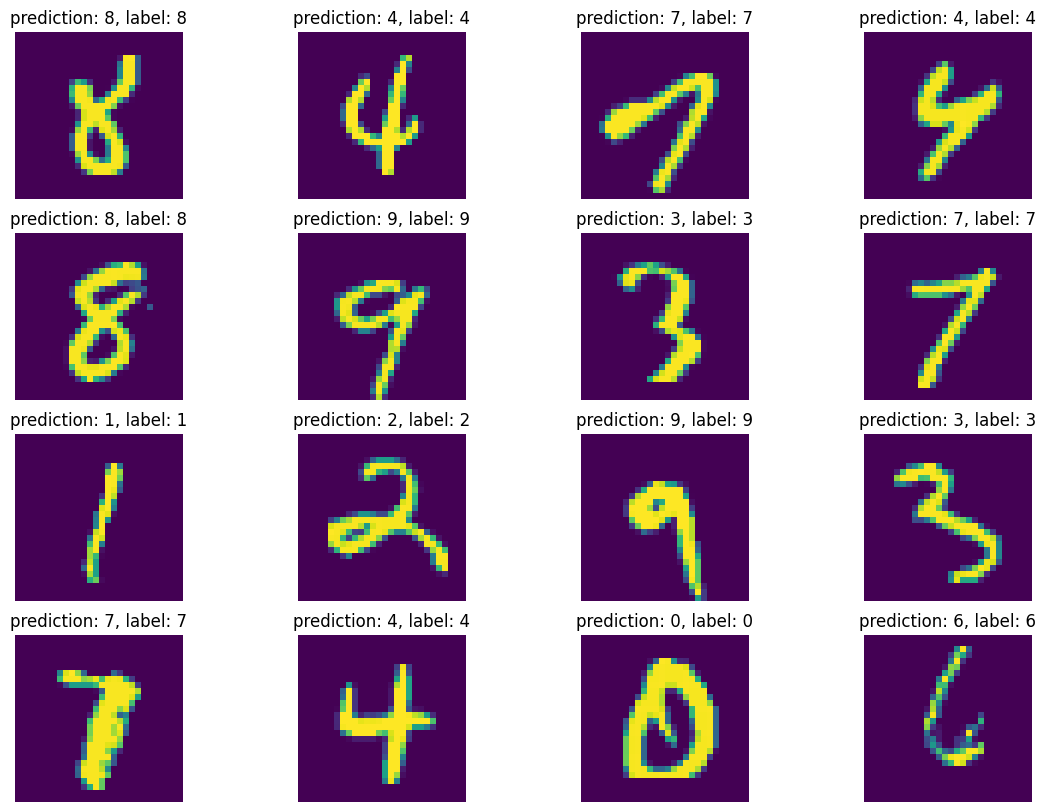

In [15]:
# model output visualization on validation part od dataset.
for image_samples, label_samples in mnist_val_loader:
    break
image_samples, label_samples = image_samples[:16].to(DEVICE), label_samples[:16].to(DEVICE)

node_model.eval()
predicted_label_samples = torch.argmax(node_model(image_samples), dim=-1).detach().cpu().numpy()
image_samples, label_samples = image_samples.detach().cpu().numpy(), label_samples.detach().cpu().numpy()

fig, axs = plt.subplots(figsize=(14, 10), nrows=4, ncols=4)
for i in range(image_samples.shape[0]):
    col = i % 4
    row = i // 4
    axs[row, col].imshow(image_samples[i][0])
    axs[row, col].axis('off')
    axs[row, col].set_title(f'prediction: {predicted_label_samples[i]}, label: {predicted_label_samples[i]}')
    
plt.show()

## Example: Generative latent function time-series model

Process for training NODE does not differ from training normal neural networks.

### Generate VAE time-series model motivation and explanation

Notation:
- $x$ - observable data (data space)
- $z$ - latent state (latent space)
- $h$ - hidden state (adding more model flexibility)
- $p(x)$ - distribution

NODE model is suitable to extrapolation at latent space. Given initial latent space state $z_{t_0} \sim p(z_{t_0})$ it is possible to acquire values of $z_{t_1}, z_{t_2}, \dots z_{t_N}$ using Neural ODE with parameters $\theta_f$. Afterward the values $z_{t_i}$ in latent space can be mapped to $x_{t_i}$ in data space with a learnable function (neural network) $f_{\theta_x}$ with . For $p(z)$ a standard normal distribution $\mathcal{N}(0, 1)$ is chosen which is common choice for VAE model (regularization component):

<center>$
\begin{align}
z_{t_0} \sim \mathcal{N}(0, I)
\end{align}
$
    
<center>$
\begin{align}
z_{t_1}, z_{t_2}, \dots z_{t_N} = ODESolve(z_{t_0}, f, [t_1, t_2, \dots, t_N], \theta_f)
\end{align}
$
    
<center>$
\begin{align}
each\ x_{t_i} \sim p(x|z_{t_i}, \theta_x) \equiv \mathcal{N}(f_{\theta_x}, cI)
\end{align}
$

![](images/node-ts-vae.png)

#### Training Algorithm

Let $x_{t_0}, x_{t_1}, \dots, x_{t_N}$ be the observable data points and $x_{t_{N+1}}, x_{t_{N+2}}, \dots, x_{t_M}$ unobservable data points which may be referred as "future data points". Steps:

1. Run RNN encoder with parameters $\phi$ backward in time from $x_{t_N}$ to $x_{t_0}$ to infer $\mu_{z_0}$ and $\sigma_{z_0}$ normal distribution of variational posterior over $z_{t_0}$:

<center>$
\begin{align}
q(z_{t_0}|\{x_{t_i}, t_i\}, \phi) = \mathcal{N}(z_{t_0}|\mu_{z_0}, \sigma_{z_0})
\end{align}
$


2. Sample $z_{t_0} \sim q(z_{t_0}|\{x_{t_i}, t_i\})$ 
3. Obtain states in latent space $z_{t_0}, z_{t_1}, \dots, z_{t_N}$ using $ODESolve(z_{t_0}, f, [t_1, t_2, \dots, t_N], \theta_f)$, where $f = \frac{dz}{dt}$
4. Map $z_{t_0}, z_{t_1}, \dots, z_{t_N}$ to $\hat{x}_{t_0}, \hat{x}_{t_1}, \dots, \hat{x}_{t_N}$ using $f_{\theta_x}$
5. Calculate gradient of ELBO (Evidence Lower BOund) estimate:

<center>$
\begin{align}
ELBO = \sum_{i=1}^N \log{p(x_{t_i}|z_{t_i}, \theta_x)} + KL(q(z_{t_0}|\{x_{t_i}, t_i\}, \phi)|| \mathcal{N}(0, I))
\end{align}
$


6. Perform backpropagation with gradient of ELBO loss with respect to $x_{t_0}, x_{t_1}, \dots, x_{t_N}$

Model-parameters reference:
- RNN encoder: $\phi$
- Neural ODE latent space decoder: $\theta_f$
- Mapping (MLP) from latent space to data space: $\theta_x$

Answers to some key questions:
- Why RNN run backward in time? RNN is ran through observable data point to obtain parameters $x_{t_N}$ to $x_{t_0}$. Since last input to RNN usually has more effect than first input it makes sense to run RNN backwards in time so last input is $x_{t_0}$.
- How RNN encoder handles missing data? One standard approach to handle missing data when working with RNN is to add time point values (or time point differences) as input. RNN models can handle sequences with different length. 

#### Inference Algorithm

Inference algorithm is same as training algorithm without steps 5 and 6 but with additional $t_{N+1}, t_{N+2}, \dots, t_M$ time points for extrapolation.

### Data Preparation

For this experiment weather dataset from [tensorflow time series regression tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series) is used. Dataset has information about multiple wather measure with 10 minute period. Only 1 hour measurments are sampled like in tensorflow regression tutorial in order to make experiments faster. It is expected that with 10 minutes samples a better accuracy can be achieved.

This section includes:
- Data collection
- Data preprocessing
- Data split (train and val)
- Data normalization

This subsection might not be too interesting but idea is to use "more realistic" dataset to test potentials of NODE VAE time-series model.

In [16]:
# Downloading weather dataset
!cd assets && wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip && unzip jena_climate_2009_2016.csv.zip

--2022-12-25 16:57:59--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.16.144, 142.250.186.48, 172.217.18.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.16.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  15.1MB/s    in 0.9s    

2022-12-25 16:58:01 (15.1 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [17]:
# Loading dataset
df = pd.read_csv('assets/jena_climate_2009_2016.csv')
print('Dataset shape (number samples, number of attributes):', df.shape)
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')  # Parse datetime
df.head()

Dataset shape (number samples, number of attributes): (420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [18]:
# Data processing. Steps:
# - Drop measurements 10 minute measurements without round hours
# - Drop Nan values (keeping it simple)
# - Replace Outliers with forward fille (previous value)

# Subsample 1 hour measurements
df = df.set_index('Date Time').resample('H').last().reset_index() 

# Drop Nan values
df = df.dropna()

# Replace outliers
df = df[~((df['wv (m/s)'] == -9999) | (df['max. wv (m/s)'] == -9999))]
df = df.set_index('Date Time').asfreq('H')
df = df.ffill(axis = 0)

print('shape after subsampling:', df.shape)
assert not df.isna().any().any()
column_names = list(df.columns)

df.head()

shape after subsampling: (70129, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
2009-01-01 01:00:00,996.62,-8.76,264.66,-9.66,93.1,3.14,2.93,0.22,1.83,2.94,1311.64,0.45,0.88,183.2
2009-01-01 02:00:00,996.86,-8.70,264.70,-9.55,93.5,3.16,2.95,0.21,1.85,2.96,1311.64,0.32,0.63,219.2
2009-01-01 03:00:00,997.06,-8.99,264.39,-9.99,92.4,3.09,2.85,0.23,1.78,2.86,1313.39,0.12,0.63,231.7
2009-01-01 04:00:00,997.37,-9.47,263.89,-10.46,92.4,2.97,2.75,0.23,1.72,2.75,1316.25,0.37,0.75,125.8


/tmp/ipykernel_1639757/209143365.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  plot_features.plot(subplots=True, ax=ax)


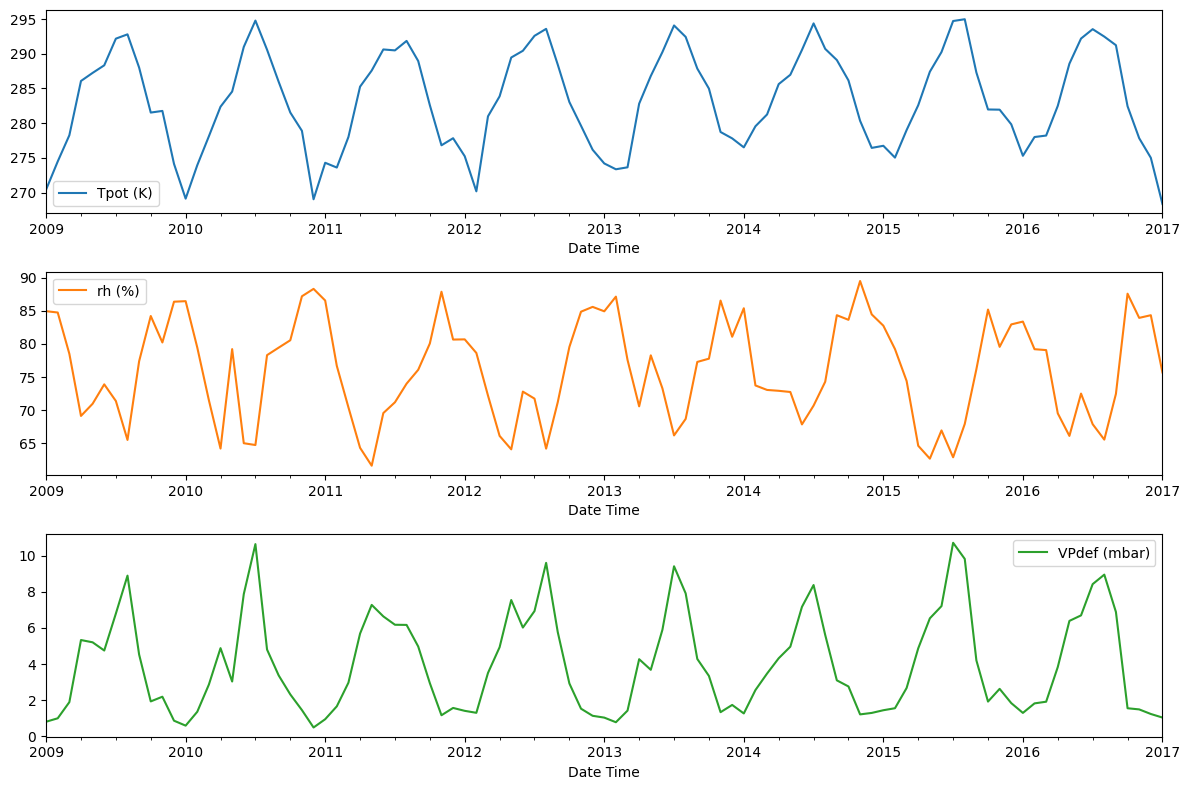

In [19]:
# Data visualization
_, ax = plt.subplots(figsize=(12, 8))
plot_cols = ['Tpot (K)', 'rh (%)', 'VPdef (mbar)']
plot_features = df[plot_cols].resample('M').mean()
plot_features.plot(subplots=True, ax=ax)
plt.tight_layout()
plt.show()

In [20]:
# Data normalization
df_train, df_val = df.iloc[:60000], df.iloc[60000:]
data_mean, data_std = df_train.mean(), df_train.std()  # avoiding data leakage
df_train = (df_train - data_mean) / data_std
df_val = (df_val - data_mean) / data_std
print('Train shape:', df_train.shape, 'Val shape:', df_val.shape)
df_train.head()

Train shape: (60000, 14) Val shape: (10129, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,0.913454,-2.080009,-2.136698,-2.040455,1.093832,-1.330058,-1.528872,-0.788885,-1.531288,-1.533262,2.312258,-1.185016,-1.249401,0.466457
2009-01-01 01:00:00,0.926793,-2.137645,-2.193832,-2.131203,1.033612,-1.346850,-1.564487,-0.782750,-1.564945,-1.568440,2.377865,-1.100100,-1.141851,0.111285
2009-01-01 02:00:00,0.955896,-2.130587,-2.189168,-2.115103,1.057700,-1.344267,-1.559738,-0.784795,-1.557466,-1.563750,2.377865,-1.185016,-1.249401,0.522417
2009-01-01 03:00:00,0.980148,-2.164698,-2.225314,-2.179505,0.991458,-1.353309,-1.583481,-0.780705,-1.583644,-1.587202,2.421355,-1.315655,-1.249401,0.665171
2009-01-01 04:00:00,1.017740,-2.221158,-2.283614,-2.248298,0.991458,-1.368809,-1.607224,-0.780705,-1.606082,-1.613000,2.492430,-1.152356,-1.197777,-0.544242


In [21]:
SELECTED_COLUMNS = ['T (degC)']
N_FEATURES = len(SELECTED_COLUMNS)

class WeatherDataset(Dataset):
    """
    PyTorch dataset wrapper for Weather dataframe
    """
    def __init__(self, data: pd.DataFrame, history_steps: int, prediction_steps: int, columns: Optional[List[str]] = None):
        """
        Args:
            data: DataFrame
            history_steps: Input sequence length
            predictions_steps: Output sequence length
        """
        super(WeatherDataset, self).__init__()
        assert data.shape[1] == 14
        if columns is None:
            columns = list(df.columns)
        
        self._data = data[columns].values
        self._t_orig = pd.to_datetime(data.index.values)
        self._t = data.index.values.astype(np.int64) // 10 ** 9 # transforming time points to raw timestamps
        self._t = self._t / 3600 # normalizing timestamps (distance between measurements is now 1.0 instead of 3600.0)
        
        self._history_steps = history_steps
        self._prediction_steps = prediction_steps
        
        self._n_samples = self._t.shape[0] - (self._history_steps + self._prediction_steps + 1)
    
    def __len__(self) -> int:
        return self._n_samples
    
    def hist_interval(self, index: int) -> Tuple[int, int]:
        """
        Calculates interval for input sequence for given index
        
        Args:
            index: Sequence index
            
        Returns:
            Input Sequence rows index range
        """
        return index, index+self._history_steps
    
    def future_interval(self, index: int) -> Tuple[int, int]:
        """
        Calculates interval for output sequence for given index
        
        Args:
            index: Sequence index
            
        Returns:
            Output Sequence rows index range
        """
        return index+self._history_steps, index+self._history_steps+self._prediction_steps
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        hist_start, hist_end = self.hist_interval(index)
        future_start, future_end = self.future_interval(index)
        
        x_obs = torch.tensor(self._data[hist_start:hist_end], dtype=torch.float32)
        t_obs = torch.tensor(self._t[hist_start:hist_end], dtype=torch.float32).unsqueeze(-1)
        x_all = torch.tensor(self._data[hist_start:future_end], dtype=torch.float32)
        t_all = torch.tensor(self._t[hist_start:future_end], dtype=torch.float32).unsqueeze(-1)
        
        return x_obs, t_obs, x_all, t_all
    
    def time(self, index: int) -> tuple:
        """
        Gets datetime values for input and output sequence for given index
        
        Args:
            index: Sequence index
            
        Returns:
            Input sequence datetime values, Output sequnce datetime values, Full sequence (input + output) datetime values
        """
        hist_start, hist_end = self.hist_interval(index)
        future_start, future_end = self.future_interval(index)
        
        t_obs = self._t_orig[hist_start:hist_end]
        t_unobs = self._t_orig[future_start:future_end]
        t_all = self._t_orig[hist_start:future_end]
        return t_obs, t_unobs, t_all
    
    
test_dataset = WeatherDataset(df_train, history_steps=4, prediction_steps=2, columns=SELECTED_COLUMNS)
x_obs, t_obs, x_all, t_all = test_dataset[0]
print('GetItem:', x_obs.shape, t_obs.shape, x_all.shape, t_all.shape)

t_obs_raw, t_unobs_raw, t_all_raw = test_dataset.time(0)
print('Time (original):', t_obs_raw.shape, t_unobs_raw.shape, t_all_raw.shape)

GetItem: torch.Size([4, 1]) torch.Size([4, 1]) torch.Size([6, 1]) torch.Size([6, 1])
Time (original): (4,) (2,) (6,)


### Custom Dataloader collate function

In order to use dataloader for sequences it is required to change `Dataloader.collate_fn()` which is a method that defines how list of items
is combined (collated) into a single tensor (batch). Read [PyTorch data utils documentation](https://pytorch.org/docs/stable/data.html) for more info.

In [22]:
def ode_dataloader_collate_func(items: List[torch.Tensor]) -> torch.Tensor:
    """
    ODE collate func: Standard way to batch sequences of dimension (T, *shape) 
    where T is time dimension and shape is feature dimension is to create batch 
    of size (B, T, *shape) but for NODE it makes more sense to do it as (T, B, *shape)
    which requires custom collate_func
    
    Args:
        items: Items gathered from WeatherDataset
    
    Returns:
        collated tensors
    """
    xs, x_ts, ys, y_ts = zip(*items)
    x, t_x, y, t_y = torch.stack(xs, dim=1), torch.stack(x_ts, dim=1), torch.stack(ys, dim=1), torch.stack(y_ts, dim=1)
    return x, t_x, y, t_y


test_loader = DataLoader(test_dataset, batch_size=10, collate_fn=ode_dataloader_collate_func)


for x, t_x, y, t_y in test_loader:
    print(x.shape, t_x.shape, y.shape, t_y.shape)
    break

torch.Size([4, 10, 1]) torch.Size([4, 10, 1]) torch.Size([6, 10, 1]) torch.Size([6, 10, 1])


In [23]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        super(RNNEncoder, self).__init__()
        self._latent_dim = latent_dim
        
        self._rnn = nn.GRU(input_dim+1, hidden_dim)
        self._lrelu = nn.LeakyReLU(0.1)
        self._hidden2latent = nn.Linear(hidden_dim, 2*latent_dim)  # outputs log_var and mean for each input
        
    def forward(self, x_obs: torch.Tensor, t_obs: torch.Tensor) -> torch.Tensor:
        # Using relative time point values instead of absolute time point values
        t_diff = torch.zeros_like(t_obs)
        t_diff[0] = 0
        t_diff[1:] = t_obs[1:] - t_obs[:-1]
        t_diff = t_diff.to(x_obs)
        
        # Add relative time points to input data
        xt = torch.cat([x_obs, t_diff], dim=-1)
        
        # Reverse input time sequence (running RNN backward in time)
        xt = torch.flip(xt, dims=[0])
        
        _, h0 = self._rnn(xt)
        h0 = self._lrelu(h0[0])
        z0 = self._hidden2latent(h0)
        
        z0_mean, z0_log_var = z0[:, :self._latent_dim], z0[:, self._latent_dim:]
        return z0_mean, z0_log_var
        
encoder = RNNEncoder(2, 3, 2)
x, t = torch.randn(4, 1, 2), torch.randn(4, 1, 1)
mean, log_var = encoder(x, t)
mean.shape, log_var.shape

(torch.Size([1, 2]), torch.Size([1, 2]))

In [24]:
class MLPEncoder(nn.Module):
    def __init__(self, traj_length: int, input_dim: int, hidden_dim: int, latent_dim: int):
        super(MLPEncoder, self).__init__()
        self._latent_dim = latent_dim
        
        self._flatten = nn.Flatten()
        self._encoder = nn.Sequential(
            nn.Linear(traj_length*(input_dim+1), hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh()
        )
        self._hidden2latent = nn.Linear(hidden_dim, 2*latent_dim)  # outputs log_var and mean for each input
        
    def forward(self, x_obs: torch.Tensor, t_obs: torch.Tensor) -> torch.Tensor:
        # Using relative time point values instead of absolute time point values
        t_diff = torch.zeros_like(t_obs)
        t_diff[0] = 0
        t_diff[1:] = t_obs[1:] - t_obs[:-1]
        t_diff = t_diff.to(x_obs)
        
        # Add relative time points to input data
        xt = torch.cat([x_obs, t_diff], dim=-1)
        
        # Reverse input time sequence (running RNN backward in time)
        xt = torch.flip(xt, dims=[0])
        
        xt = torch.permute(xt, [1, 0, 2])
        xt = self._flatten(xt)
        h0 = self._encoder(xt)
        z0 = self._hidden2latent(h0)
        
        z0_mean, z0_log_var = z0[:, :self._latent_dim], z0[:, self._latent_dim:]
        return z0_mean, z0_log_var
        
encoder = MLPEncoder(4, 2, 3, 2)
x, t = torch.randn(4, 1, 2), torch.randn(4, 1, 1)
mean, log_var = encoder(x, t)
mean.shape, log_var.shape

(torch.Size([1, 2]), torch.Size([1, 2]))

In [25]:
class MLPODEF(ODEF):
    def __init__(self, dim: int, hidden_dim: int, n_layers: int = 2):
        super(ODEF, self).__init__()
        assert n_layers >= 1, f'Minimum number of layers is 1 but found {n_layers}'
        layers_args = [[hidden_dim, hidden_dim] for _ in range(n_layers)]
        layers_args[0][0] = dim+1 # setting input dimension (including time dimension)
        layers_args[-1][1] = dim # setting output dimension
        
        self._model = nn.Sequential(*[self._create_mlp_layer(*args) for args in layers_args])
        
    @staticmethod
    def _create_mlp_layer(input_dim: int, output_dim: int) -> nn.Module:
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.LeakyReLU(0.1)
        )
    
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        xt = torch.cat([x, t], dim=-1)
        return self._model(xt)

class NODEDecoder(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_dim: int):
        super(NODEDecoder, self).__init__()
        
        self._ode = NeuralODE(MLPODEF(latent_dim, hidden_dim, n_layers=2))
        self._latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self._lrelu = nn.LeakyReLU(0.1)
        self._hidden2output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z0: torch.Tensor, ts: torch.Tensor):
        zs = self._ode(z0, ts, full_sequence=True)
        hs = self._lrelu(self._latent2hidden(zs))
        xs = self._lrelu(self._hidden2output(hs))
        return xs
        
decoder = NODEDecoder(2, 3, 3)
z0, ts = torch.randn(1, 2), torch.randn(3, 1, 1)
xs = decoder(z0, ts)
xs.shape

torch.Size([3, 1, 3])

In [26]:
class ODEVAE(nn.Module):
    def __init__(self, observable_dim: int, hidden_dim: int, latent_dim: int):
        super(ODEVAE, self).__init__()
        
        self._encoder = RNNEncoder(observable_dim, hidden_dim, latent_dim)
        self._decoder = NODEDecoder(latent_dim, hidden_dim, observable_dim)
        
    def forward(self, x: torch.Tensor, t_obs: torch.Tensor, t_all: Optional[torch.Tensor] = None, generate: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        t_all = t_all if t_all is not None else t_obs
        assert t_all.shape[0] >= t_obs.shape[0], f'All time points must contain at lease observable time points. Shapes (all, obs): {t_all.shape[0]}, {t_observable.shape[0]}'
        
        z0_mean, z0_log_var = self._encoder(x, t_obs)
        z0 = z0_mean if not generate else z0_mean + torch.randn_like(z0_mean) * torch.exp(0.5 * z0_log_var)
        x_hat = self._decoder(z0, t_all)
        return x_hat, z0_mean, z0_log_var
    
vae = ODEVAE(2, 3, 2)
x, t_observable, t_all = torch.randn(4, 1, 2), torch.randn(4, 1, 1), torch.randn(6, 1, 1)
x_hat, z0_mean, z0_log_var = vae(x, t_observable, t_all)
x_hat.shape, z0_mean.shape, z0_log_var.shape

(torch.Size([6, 1, 2]), torch.Size([1, 2]), torch.Size([1, 2]))

In [27]:
class ODEVAE2(nn.Module):
    def __init__(self, observable_dim: int, hidden_dim: int, latent_dim: int):
        super(ODEVAE2, self).__init__()
        
        self._encoder = MLPEncoder(24, observable_dim, hidden_dim, latent_dim)
        self._decoder = NODEDecoder(latent_dim, hidden_dim, observable_dim)
        
    def forward(self, x: torch.Tensor, t_obs: torch.Tensor, t_all: Optional[torch.Tensor] = None, generate: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        t_all = t_all if t_all is not None else t_obs
        assert t_all.shape[0] >= t_obs.shape[0], f'All time points must contain at lease observable time points. Shapes (all, obs): {t_all.shape[0]}, {t_observable.shape[0]}'
        
        z0_mean, z0_log_var = self._encoder(x, t_obs)
        z0 = z0_mean if not generate else z0_mean + torch.randn_like(z0_mean) * torch.exp(0.5 * z0_log_var)
        x_hat = self._decoder(z0, t_all)
        return x_hat, z0_mean, z0_log_var
    
vae = ODEVAE(2, 3, 2)
x, t_observable, t_all = torch.randn(4, 1, 2), torch.randn(4, 1, 1), torch.randn(6, 1, 1)
x_hat, z0_mean, z0_log_var = vae(x, t_observable, t_all)
x_hat.shape, z0_mean.shape, z0_log_var.shape

(torch.Size([6, 1, 2]), torch.Size([1, 2]), torch.Size([1, 2]))

In [28]:
class ELBO(nn.Module):
    def __init__(self, noise_std: float):
        super(ELBO, self).__init__()
        self._noise_std = noise_std
        
    def forward(self, x_hat: torch.Tensor, x_true: torch.Tensor, z0_mean: torch.Tensor, z0_log_var: torch.Tensor) -> torch.Tensor:
        # print('C:', y_hat, y_true, z0_mean, z0_log_var)
        kl_div_loss = torch.sum(1 + z0_log_var - torch.square(z0_mean) - torch.exp(z0_log_var), dim=-1) / 2
        likelihood_loss = torch.mean(torch.sum(torch.pow(x_hat - x_true, 2) / (2*self._noise_std), dim=-1), dim=0) # summation over last dimension and mean over time dimension
        batch_loss = likelihood_loss - kl_div_loss
        return torch.mean(batch_loss), torch.mean(kl_div_loss), torch.mean(likelihood_loss)
    

elbo = ELBO(0.01)

y_hat = torch.tensor([[[1.0, 1.0]]], dtype=torch.float32)
y_true = torch.tensor([[[1.05, 1.1]]], dtype=torch.float32)
z0_mean = torch.tensor([-0.1, 0.05], dtype=torch.float32)
z0_log_var = torch.tensor([0.0, 0.05], dtype=torch.float32)
print('Good loss:', elbo(y_hat, y_true, z0_mean, z0_log_var))

y_hat = torch.tensor([[[1.0, 1.0]]], dtype=torch.float32)
y_true = torch.tensor([[[1.0, 1.0]]], dtype=torch.float32)
z0_mean = torch.tensor([0.0, 0.0], dtype=torch.float32)
z0_log_var = torch.tensor([0.0, 0.0], dtype=torch.float32)
print('Perfect loss:', elbo(y_hat, y_true, z0_mean, z0_log_var))

Good loss: (tensor(0.63), tensor(-0.01), tensor(0.62))
Perfect loss: (tensor(0.), tensor(0.), tensor(0.))


In [ ]:
def train_model(
    model: nn.Module, 
    train_loader: torch.utils.data.DataLoader, 
    val_loader: torch.utils.data.DataLoader, 
    device: Union[torch.device, str],
    n_epochs: int = 10
) -> dict:
    """
    Train ODEVAE model
    
    Args:
        model: ODEVAE
        train_loader: Train data
        val_loader: Val data
        device: cpu/cuda
        n_epochs: Number of epochs to train
        
    Returns:
        Loss history
    """
    loss_func = ELBO(0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    
    with tqdm(range(1, n_epochs+1)) as pbar:
        for epoch in pbar:
            history = {
                'train': {
                    'loss': [],
                    'likelihood_loss': [],
                    'kldiv_loss': []
                },
                'val': {
                    'loss': [],
                    'likelihood_loss': [],
                    'kldiv_loss': []
                }  
            }
            
            # Train
            model.train()
            for x_obs, t_obs, x_all, t_all in tqdm(train_loader, desc='training', unit='batch'):
                # x - history, t - time, y - future
                x_obs, t_obs, x_all, t_all = x_obs.to(device), t_obs.to(device), x_all.to(device), t_all.to(device)
                batch_size = x.shape[0]
                
                optimizer.zero_grad()
                x_hat, z0_mean, z0_log_var = model(x_obs, t_obs, t_all)
                loss, kl_div_loss, likelihood_loss = loss_func(x_hat, x_all, z0_mean, z0_log_var)  # TODO, save all losses
                loss.backward()
                optimizer.step()
                
                history['train']['loss'].append(loss.detach().cpu().item())
                history['train']['likelihood_loss'].append(likelihood_loss.detach().cpu().item())
                history['train']['kldiv_loss'].append(kl_div_loss.detach().cpu().item())
                
            # Evaluation
            model.eval()
            with torch.no_grad():
                for x_obs, t_obs, x_all, t_all in tqdm(val_loader, desc='validation', unit='batch'):
                    x_obs, t_obs, x_all, t_all = x_obs.to(device), t_obs.to(device), x_all.to(device), t_all.to(device)
                    batch_size = x.shape[0]
                    
                    x_hat, z0_mean, z0_log_var = model(x_obs, t_obs, t_all)
                    loss, kl_div_loss, likelihood_loss = loss_func(x_hat, x_all, z0_mean, z0_log_var)  # TODO, save all losses

                    history['val']['loss'].append(loss.detach().cpu().item())
                    history['val']['likelihood_loss'].append(likelihood_loss.detach().cpu().item())
                    history['val']['kldiv_loss'].append(kl_div_loss.detach().cpu().item())
               
            
            description = ''
            for subset_name, losses in history.items():
                for loss_name, loss_values in losses.items():
                    loss_value = sum(loss_values) / len(loss_values)
                    description += f'{subset_name} {loss_name}: {loss_value:.4f}, '
            description = description[:-2]  # remove ", " at end
            pbar.set_description(description)
            

BATCH_SIZE = 32
NUM_WORKERS = 4
H_STEP = 24  # hours
P_STEP = 24  # hours

train_dataset = WeatherDataset(df_train, history_steps=H_STEP, prediction_steps=P_STEP, columns=SELECTED_COLUMNS)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, collate_fn=ode_dataloader_collate_func)
val_dataset = WeatherDataset(df_val, history_steps=H_STEP, prediction_steps=P_STEP, columns=SELECTED_COLUMNS)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, collate_fn=ode_dataloader_collate_func)

ode_vae = ODEVAE2(N_FEATURES, 128, 64).to(DEVICE)
train_model(ode_vae, train_data_loader, val_data_loader, device=DEVICE, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

training:   0%|          | 0/1874 [00:00<?, ?batch/s]

validation:   0%|          | 0/315 [00:00<?, ?batch/s]

training:   0%|          | 0/1874 [00:00<?, ?batch/s]

validation:   0%|          | 0/315 [00:00<?, ?batch/s]

training:   0%|          | 0/1874 [00:00<?, ?batch/s]

validation:   0%|          | 0/315 [00:00<?, ?batch/s]

training:   0%|          | 0/1874 [00:00<?, ?batch/s]

validation:   0%|          | 0/315 [00:00<?, ?batch/s]

training:   0%|          | 0/1874 [00:00<?, ?batch/s]

validation:   0%|          | 0/315 [00:00<?, ?batch/s]

training:   0%|          | 0/1874 [00:00<?, ?batch/s]

validation:   0%|          | 0/315 [00:00<?, ?batch/s]

training:   0%|          | 0/1874 [00:00<?, ?batch/s]

validation:   0%|          | 0/315 [00:00<?, ?batch/s]

training:   0%|          | 0/1874 [00:00<?, ?batch/s]

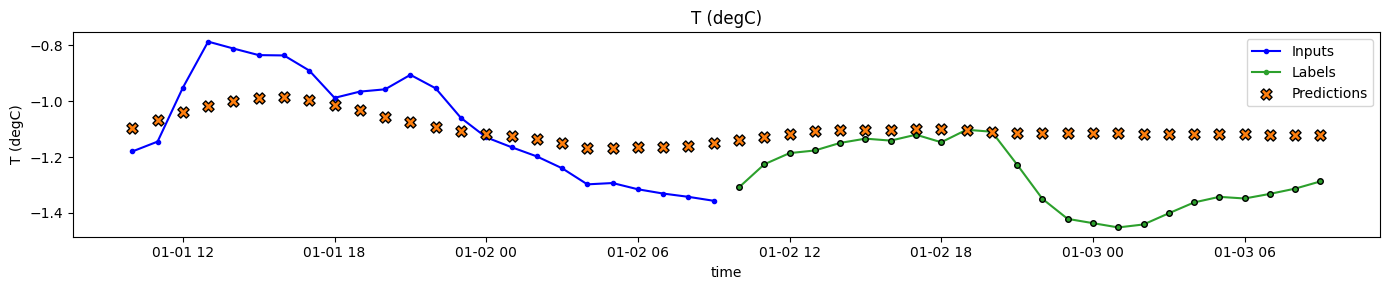

In [44]:
def plot_ts_predictions(
    x_obs: np.ndarray, 
    t_obs_orig: np.ndarray, 
    x_unobs: np.ndarray, 
    t_unobs_orig: np.ndarray, 
    cols: Optional[List[int]] = None, 
    x_all_hat: Optional[np.ndarray] = None, 
    col_names: Optional[List[str]] = None
) -> plt.Figure:
    """
    Plots time series with optional predictions
    
    Args:
        x_obs: Observable data (history)
        t_obs_orig: Observable data corresponding datetime points
        x_unobs: Unobservable data (future)
        t_unobs_orig: Unobservable data corresponding datetime points
        cols: Column indices to plot
        x_all_hat: Predictions
        col_names: Column names for plot
    
    Returns:
        Plot figure
    """
    if cols is None:
        cols = list(range(x_obs.shape[-1]))
    
    n_cols = len(cols)
    fig = plt.figure(figsize=(14, 3*n_cols))
    for plot_index, col_index in enumerate(cols):
        plt.subplot(n_cols, 1, plot_index+1)
        plt.xlabel('time')
        plt.ylabel(str(col_index) if col_names is None else col_names[col_index])
        plt.title(str(col_index) if col_names is None else col_names[col_index])
        
        plt.plot(t_obs_orig, x_obs[:, 0, col_index], label='Inputs', c='blue', marker='.', zorder=0)
        plt.plot(t_unobs_orig, x_unobs[:, 0, col_index], label='Labels', marker='.', c='#2ca02c', zorder=2)
        plt.scatter(t_unobs_orig, x_unobs[:, 0, col_index], marker='.', edgecolors='k', c='#2ca02c', s=64, zorder=2)
        if x_all_hat is not None: 
            t_all = np.hstack([t_obs_orig, t_unobs_orig])
            plt.scatter(t_all, x_all_hat[:, 0, col_index], label='Predictions', marker='X', edgecolors='k', c='#ff7f0e', s=64, zorder=3)
        plt.legend()
        
    plt.tight_layout()
    return fig



sample_index = 1354
x_obs, t_obs, x_all, t_all = val_dataset[sample_index]
x_obs, t_obs, x_all, t_all = [val.to(DEVICE).unsqueeze(1) for val in [x_obs, t_obs, x_all, t_all]]
ode_vae.eval()
x_hat, _, _ = ode_vae(x_obs, t_obs, t_all)
x_obs, x_all, x_hat = [val.detach().cpu().numpy() for val in [x_obs, x_all, x_hat]]
t_obs_orig, t_unobs_orig, t_all_orig = val_dataset.time(sample_index)
x_unobs, x_hat_obs, x_hat_unobs = x_all[-P_STEP:], x_hat[:H_STEP], x_hat[-P_STEP:]

plot_ts_predictions(x_obs, t_obs_orig, x_unobs, t_unobs_orig, x_all_hat=x_hat, col_names=SELECTED_COLUMNS)
plt.show()